# Simple Token Distribution

A cadCAD sketch exploring an inflationary token model managed and distributed by community contributors.


## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [1]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/site-packages
Requires: funcy, pandas, fn, pathos
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

In [2]:
# Python
import numpy as np
import random as random

# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD_diagram import diagram_from_config

# Notebook setup
experiment = Experiment()
del configs[:]

## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [3]:
# The initial states of the cadCAD model
genesis_states = {
    # A variable that tracks the total amount of tokens in the system
    'tokens': 1,
    # Contributor stats
    'contributors': {
        i: {'balance': 1, 'skill_level': 5, 'impact': 0} for i in range(1)    
    },
    # The pool of tokens to reward contributors
    'treasury': 0,
}

# The parameters to run the model
params = {
    # Timesteps
    'T': range(52),
    # Parallel runs
    'N': 1,
    # Params passed to policy and state update functions
    'M': {
        # Number of tokens to mint to the treasury 
        'weekly_token_minting': [1000],
        # Number of new contributors
        'weekly_new_contributors': [3],
        # Maximum amount of effort per week
        'maximum_effort': [7],
        # Maximum skill_level of any contributor
        'maximum_skill_level': [10]
    }
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

We start policy functions with p_ so that they're easier to keep track of when we put them into state update blocks. 

In [4]:
# Mint tokens on a weekly basis (each timestep)
def p_mint_tokens(params, step, sH, s):
    minted_tokens = params['weekly_token_minting']
    return ({'minted_tokens': minted_tokens})

# Do work to earn tokens
def p_effort(params, step, sH, s):
    effort = random.randint(1, params['maximum_effort'])
    return ({'effort': effort})

# New community contributors
def p_new_community_contributors(params, step, sH, s):
    latest_contributor_key = list(s['contributors'])[-1]
    new_contributors = {
        i: {
            'balance': 0,
            'skill_level': random.randint(1, params['maximum_skill_level'])
        } for i in range(latest_contributor_key + 1, latest_contributor_key + params['weekly_new_contributors'])
    }
    return ({'new_contributors': new_contributors})


## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

We start policy functions with p_ so that they're easier to keep track of when we put them into state update blocks.

In [5]:
# Update token count based on weekly minting
def s_update_token_count(params, step, sH, s, _input):
    y = 'tokens'
    x = s[y]
    x += _input['minted_tokens']
    return (y, x)

# Put newly minted tokens into the community treasury
def s_mint_to_treasury(params, step, sH, s, _input):
    y = 'treasury'
    x = s[y]
    x += _input['minted_tokens']
    return (y, x)

# Give new contributors accounts
def s_new_contributor_accounts(params, step, sH, s, _input):
    y = 'contributors'
    x = s[y]
    x.update(_input['new_contributors'])
    return (y, x)

# Update community treasury based on contribution rewards
def s_distribute_treasury(params, step, sH, s, _input):
    y = 'treasury'
    x = s[y]
    for i in s['contributors']:
        impact = s['contributors'][i]['skill_level'] * _input['effort']
        if x >= impact:
            x -= impact
        else:
            break
    return (y, x)

# Distribute rewards to contributors
def s_reward_contributions(params, step, sH, s, _input):
    y = 'contributors'
    x = s[y]
    for i in x:
        impact = s['contributors'][i]['skill_level'] * _input['effort']
        if s['treasury'] >= impact:
            x[i]['balance'] += impact
        else:
            break
    return (y, x)


## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [6]:
partial_state_update_blocks = [
    { 
        # Mint tokens
        'policies': { 
            'minted_tokens': p_mint_tokens
        },
        # Update token count and community treasury
        'variables': {
            'tokens': s_update_token_count,
            'treasury': s_mint_to_treasury
        }
    },
    {
        # Add new contributors
        'policies': {
            'new_contributors': p_new_community_contributors
        },
        # Give contributors accounts
        'variables': {
            'contributors': s_new_contributor_accounts
        }
    },
    {
        # Do work
        'policies': {
            'effort': p_effort
        },
        # Recognize and reward contributors
        'variables': {
            'treasury': s_distribute_treasury,
            'contributors': s_reward_contributions
        }
    }
    # TO DO: 
    # Add in intermediate step between doing work and getting rewarded
    # At this step contributors would earn impact points
    # Then in the reward stage the weekly rewards would be distributed between contributors based on impact points
    # 20% of rewards would stay in the treasury for long-term projects, and 80% would go to weekly contributors 
]

## Running the cadCAD Engine

In [7]:
experiment.append_configs(
    initial_state = genesis_states,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = config_sim(params)
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs) 
raw_system_events, tensor_field, sessions = simulation.execute() 



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (52, 4, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.09s


## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

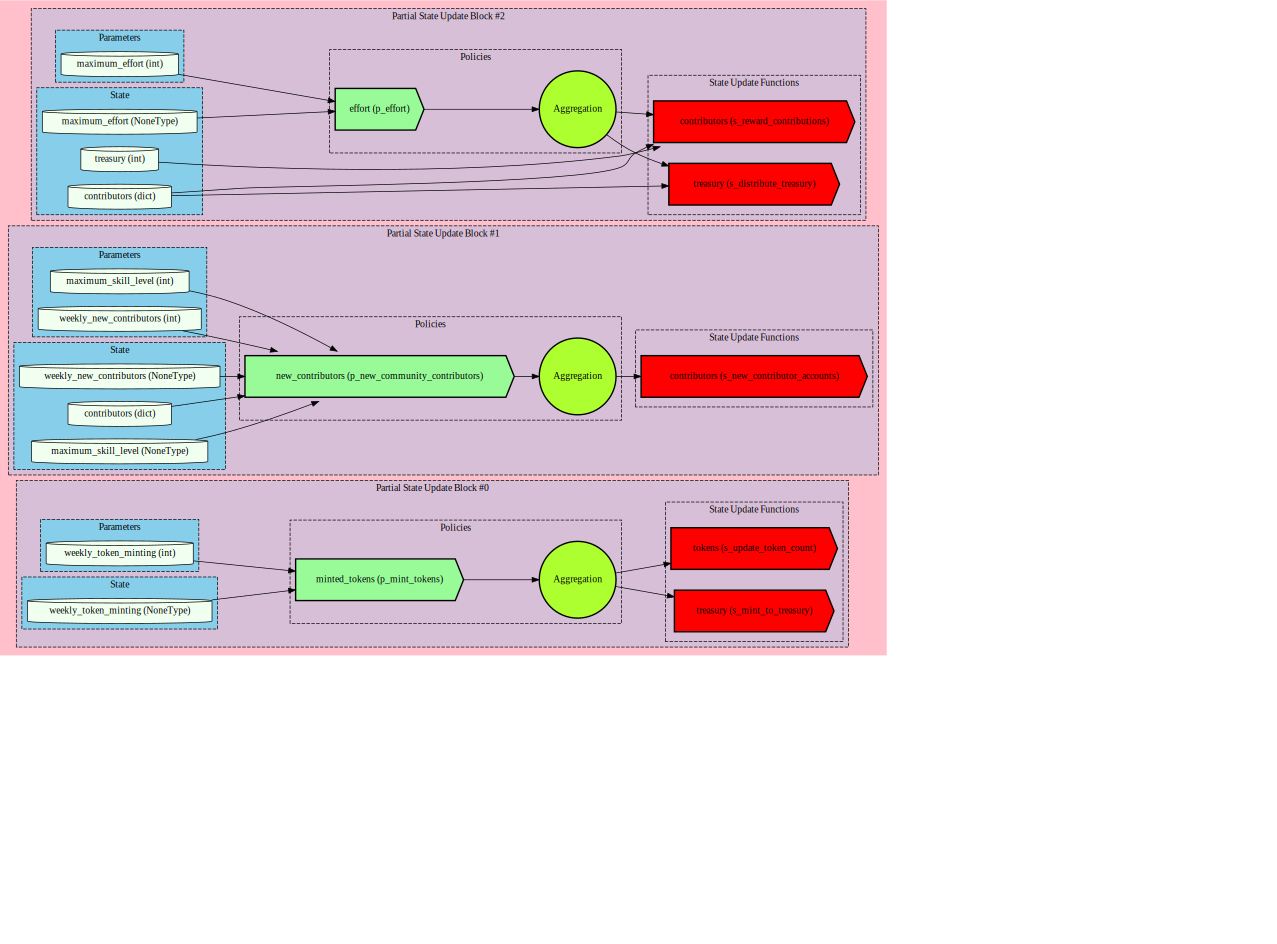

In [8]:
diagram_from_config(configs[0])

In [9]:
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

tokens  \
subset run timestep substep           
0      1   0        0             1   
           1        1          1001   
                    2          1001   
                    3          1001   
           2        1          2001   
...                             ...   
           51       2         51001   
                    3         51001   
           52       1         52001   
                    2         52001   
                    3         52001   

                                                                  contributors  \
subset run timestep substep                                                      
0      1   0        0        {0: {'balance': 1, 'skill_level': 5, 'impact':...   
           1        1        {0: {'balance': 1, 'skill_level': 5, 'impact':...   
                    2        {0: {'balance': 1, 'skill_level': 5, 'impact':...   
                    3        {0: {'balance': 11, 'skill_level': 5, 'impact'...   
           2        1        {0: {'balance': 11, 'skill_level': 5, 'impact'...   
...                                                                        ...   
           51       2        {0: {'balance': 921, 'skill_level': 5, 'impact...   
                    3        {0: {'balance': 931, 'skill_level': 5, 'impact...   
           52       1        {0: {'balance': 931, 'skill_level': 5, 'impact...   
                    2        {0: {'balance': 931, 'skill_level': 5, 'impact...   
                    3        {0: {'balance': 951, 'skill_level': 5, 'impact...   

                             treasury  simulation  
subset run timestep substep                        
0      1   0        0               0           0  
           1        1            1000           0  
                    2            1000           0  
                    3             956           0  
           2        1            1956           0  
...                               ...         ...  
           51       2            1459           0  
                    3             297           0  
           52       1            1297           0  
                    2            1297           0  
                    3               9           0  

[157 rows x 4 columns]

In [10]:
raw_system_events

'balance': 455, 'skill_level': 7},
   70: {'balance': 585, 'skill_level': 9},
   71: {'balance': 360, 'skill_level': 6},
   72: {'balance': 600, 'skill_level': 10},
   73: {'balance': 531, 'skill_level': 9},
   74: {'balance': 590, 'skill_level': 10},
   75: {'balance': 477, 'skill_level': 9},
   76: {'balance': 424, 'skill_level': 8},
   77: {'balance': 46, 'skill_level': 1},
   78: {'balance': 184, 'skill_level': 4},
   79: {'balance': 135, 'skill_level': 3},
   80: {'balance': 90, 'skill_level': 2},
   81: {'balance': 390, 'skill_level': 10},
   82: {'balance': 234, 'skill_level': 6},
   83: {'balance': 160, 'skill_level': 5},
   84: {'balance': 32, 'skill_level': 1},
   85: {'balance': 243, 'skill_level': 9},
   86: {'balance': 243, 'skill_level': 9},
   87: {'balance': 52, 'skill_level': 2},
   88: {'balance': 156, 'skill_level': 6},
   89: {'balance': 160, 'skill_level': 8},
   90: {'balance': 140, 'skill_level': 7},
   91: {'balance': 85, 'skill_level': 5},
   92: {'balance': 68